In [1]:
import pandas as pd 
df=pd.read_csv('c:/data/movie/review.csv',encoding='utf-8')
df.head()

,code,review,point,label
0,189141,NaN,9,1
1,189141,끈끈한 연대와 끝없는 투쟁만이 변화를 가져올 수 있다는 걸 깨우치게 해준 영화. 가...,10,1
2,189141,기대안하고 보았는데 재미있고 감동도 있는 것 같습니다. 고맙습니다.,10,1
3,189141,너무 재밌었어요 잘봤습니다~,10,1
4,189141,보기 쉽지않은 평점 9점대 영화길래 혹해서 봤는데 영화보다가 잠들 뻔 한 적은 처음...,1,0


In [2]:
#정규표현식으로  한글,스페이스 문자를 제외하고 모두 제거
df['review']=df['review'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','')
df[:5]

,code,review,point,label
0,189141,NaN,9,1
1,189141,끈끈한 연대와 끝없는 투쟁만이 변화를 가져올 수 있다는 걸 깨우치게 해준 영화 가슴...,10,1
2,189141,기대안하고 보았는데 재미있고 감동도 있는 것 같습니다 고맙습니다,10,1
3,189141,너무 재밌었어요 잘봤습니다,10,1
4,189141,보기 쉽지않은 평점 점대 영화길래 혹해서 봤는데 영화보다가 잠들 뻔 한 적은 처음입...,1,0


In [3]:
import numpy as np 
#결측값 개수 확인
df['review'].replace('', np.nan, inplace=True )
print(df.isnull().sum())

code        0
review    180
point       0
label       0
dtype: int64


In [4]:
df=df.dropna(how='any') #결측값이 있는 샘플 제거

In [5]:
X=df[['review']] #독립변수
y=df['label'] #종속변수
y.value_counts()

1    893
0    283
Name: label, dtype: int64

In [6]:
from imblearn.under_sampling import RandomUnderSampler 
X_sample,y_sample=RandomUnderSampler(random_state=0).fit_sample(X,y)
X_samp=pd.DataFrame(data=X_sample, columns=['review'])
y_samp=pd.DataFrame(data=y_sample, columns=['label'])
df_samp=pd.concat([X_samp,y_samp],axis=1)

In [7]:
df_samp.label.value_counts()

1    283
0    283
Name: label, dtype: int64

In [8]:
from konlpy.tag import Okt
okt=Okt()
#불용어
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
X=[]
y=[]
for idx,sentence in enumerate(df_samp['review']):
    temp = []
    #temp = okt.morphs(sentence, stem=True) 
    temp = okt.nouns(sentence)
    #print(temp)
	# 불용어가 아닌 단어들의 목록
    temp = [word for word in temp if not word in stopwords] 
    #print(temp)
    X.append(temp)
    y.append(df_samp.iloc[idx,1]) #0,1 값을 리스트에 추가

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer 
tokenizer=Tokenizer()
tokenizer.fit_on_texts(X) 

In [10]:
threshold=2
total_cnt=len(tokenizer.word_index)
rare_cnt=0
for key,value in tokenizer.word_counts.items():
    if value < threshold:
        rare_cnt += 1

print(total_cnt)  #단어수  
print(rare_cnt) #희귀단어수
print(rare_cnt*100/total_cnt ) #희귀 단어의 비율

989
251
25.37917087967644


In [11]:
vocab_size=total_cnt - rare_cnt + 1  #단어 집합의 사이즈
vocab_size 

739

In [12]:
tokenizer=Tokenizer(vocab_size)
tokenizer.fit_on_texts(X) 
i=0
for word in list(tokenizer.word_index.keys()):
    print(word, tokenizer.word_index[word])
    i+=1
    if i>5: break 

영화 1
연기 2
감동 3
진짜 4
스토리 5
배우 6


In [13]:
X2=tokenizer.texts_to_sequences(X)

In [14]:
#단어가 하나도 없는 샘플들
drop_X=[index for index,sentence in enumerate(X2) if len(sentence) < 1]
drop_X[:10]

[11, 47, 69, 99, 106, 164, 234, 296, 301, 336]

In [15]:
X=np.delete(X2, drop_X, axis=0)
y=np.delete(y, drop_X, axis=0)

121
8.38138686131387


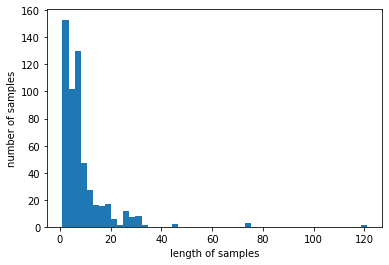

In [16]:
import matplotlib.pyplot as plt 
max_len=max(len(l) for l in X) 
print(max_len) #최대 리뷰 길이
print(sum(map(len,X))/len(X)) #평균 리뷰 길이
plt.hist([len(s) for s in X], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [17]:
from tensorflow.keras.preprocessing.sequence import pad_sequences 
#제로패딩
X=pad_sequences(X, maxlen=max_len)
max(X[0])

334

In [18]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, stratify=y, random_state=10)

In [19]:
from tensorflow.keras.layers import Embedding, Dense, LSTM 
from tensorflow.keras.models import Sequential 
model=Sequential()
model.add(Embedding(vocab_size,10))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid', name='output'))
model.compile(optimizer='sgd',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 10)          7390      
_________________________________________________________________
lstm (LSTM)                  (None, 64)                19200     
_________________________________________________________________
output (Dense)               (None, 1)                 65        
Total params: 26,655
Trainable params: 26,655
Non-trainable params: 0
_________________________________________________________________


In [20]:
hist=model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Train on 350 samples, validate on 88 samples
Epoch 1/50
350/350 [==============================] - 3s 10ms/sample - loss: 0.6935 - accuracy: 0.4714 - val_loss: 0.6934 - val_accuracy: 0.4773
Epoch 2/50
350/350 [==============================] - 0s 605us/sample - loss: 0.6935 - accuracy: 0.4629 - val_loss: 0.6937 - val_accuracy: 0.4205
Epoch 3/50
350/350 [==============================] - 0s 268us/sample - loss: 0.6934 - accuracy: 0.4800 - val_loss: 0.6939 - val_accuracy: 0.4318
Epoch 4/50
350/350 [==============================] - 0s 268us/sample - loss: 0.6934 - accuracy: 0.5057 - val_loss: 0.6941 - val_accuracy: 0.4318
Epoch 5/50
350/350 [==============================] - 0s 265us/sample - loss: 0.6934 - accuracy: 0.5086 - val_loss: 0.6943 - val_accuracy: 0.4318
Epoch 6/50
350/350 [==============================] - 0s 266us/sample - loss: 0.6933 - accuracy: 0.5114 - val_loss: 0.6945 - val_accuracy: 0.4318
Epoch 7/50
350/350 [==============================] - 0s 262us/sample - loss: 0.

In [21]:
score=model.evaluate(X_test, y_test, verbose=0)
score

[0.6933714975010264, 0.5]

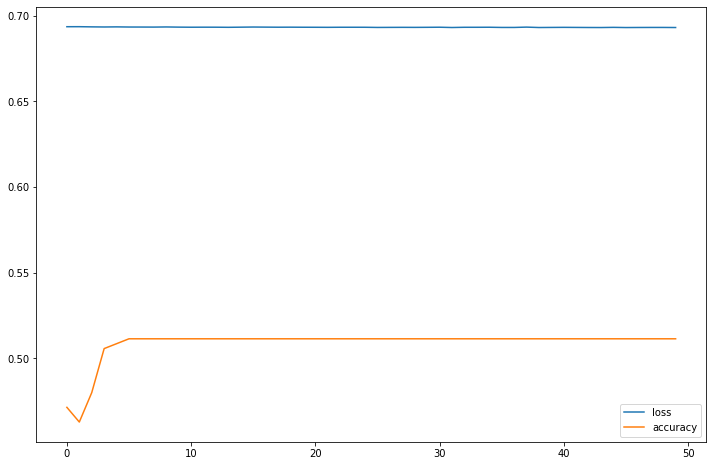

In [22]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['accuracy'])
plt.legend(['loss','accuracy'])
plt.show()